# Summarizing Messages

### Set the OpenAI API Key as an Environment Variable

In [1]:
%load_ext dotenv
%dotenv
%load_ext mypy_ipython

### Import Relevant Classes and Functions

In [2]:
from langgraph.graph import StateGraph, START, END, MessagesState
from langchain_openai.chat_models import ChatOpenAI
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, RemoveMessage
from typing import Literal

### Define the State

In [3]:
class State(MessagesState):
    summary: str

In [4]:
test_state = State()

In [5]:
test_state["summary"]

KeyError: 'summary'

In [6]:
bool(test_state.get("summary", ""))

False

### Define the Nodes

In [7]:
chat = ChatOpenAI(model = "gpt-4o", 
                  seed = 365, 
                  temperature = 0, 
                  max_completion_tokens = 100)

In [8]:
def ask_question(state: State) -> State:
    
    print(f"\n-------> ENTERING ask_question:")
    
    question = "What is your question?"
    print(question)
    
    return State(messages = [AIMessage(question), HumanMessage(input())])

In [9]:
def chatbot(state: State) -> State:
    
    print(f"\n-------> ENTERING chatbot:")
    for i in state["messages"]:
        i.pretty_print()
        
    system_message = f'''
    Here's a quick summary of what's been discussed so far:
    {state.get("summary", "")}
    
    Keep this in mind as you answer the next question.
    '''
    
    response = chat.invoke([SystemMessage(system_message)] + state["messages"])
    response.pretty_print()
    
    return State(messages = [response])

In [10]:
def ask_another_question(state: State) -> State:
    
    print(f"\n-------> ENTERING ask_another_question:")
    
    question = "Would you like to ask one more question (yes/no)?"
    print(question)
    
    return State(messages = [AIMessage(question), HumanMessage(input())])

In [18]:
def summarize_and_delete_messages(state: State) -> State:
    print(f"\n-------> ENTERING summarize_and_delete_messages:")
    
    new_conversation = ""
    for i in state["messages"]:
        new_conversation += f"{i.type}: {i.content}\n\n"
        
    summary_instructions = f'''
Update the ongoing summary by incorporating the new lines of conversation below.  
Build upon the previous summary rather than repeating it so that the result  
reflects the most recent context and developments.


Previous Summary:
{state.get("summary", "")}

New Conversation:
{new_conversation}
'''
    
    print(summary_instructions)
    
    summary = chat.invoke([HumanMessage(summary_instructions)])
    
    remove_messages = [RemoveMessage(id = i.id) for i in state["messages"][:]]
    
    return State(messages = remove_messages, summary = summary.content)

### Define the Routing Function

In [19]:
def routing_function(state: State) -> Literal["summarize_and_delete_messages", "__end__"]:
    
    if state["messages"][-1].content == "yes":
        return "summarize_and_delete_messages"
    else:
        return "__end__"

### Define the Graph

In [20]:
graph = StateGraph(State)

In [21]:
graph.add_node("ask_question", ask_question)
graph.add_node("chatbot", chatbot)
graph.add_node("ask_another_question", ask_another_question)
graph.add_node("summarize_and_delete_messages", summarize_and_delete_messages)

graph.add_edge(START, "ask_question")
graph.add_edge("ask_question", "chatbot")
graph.add_edge("chatbot", "ask_another_question")
graph.add_conditional_edges(source = "ask_another_question", 
                            path = routing_function)
graph.add_edge("summarize_and_delete_messages", "ask_question")

In [22]:
graph_compiled = graph.compile()

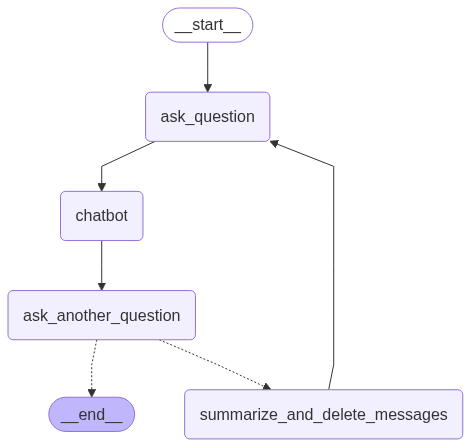

In [23]:
graph_compiled

### Test the Graph

In [24]:
graph_compiled.invoke(State(messages = []))


-------> ENTERING ask_question:
What is your question?


 What is Langston Hughes shortest poem?



-------> ENTERING chatbot:
================================== Ai Message ==================================

What is your question?
================================ Human Message =================================

What is Langston Hughes shortest poem?
================================== Ai Message ==================================

Langston Hughes's shortest poem is often considered to be "Dreams," which is concise yet powerful. It reads:

```
Hold fast to dreams
For if dreams die
Life is a broken-winged bird
That cannot fly.

Hold fast to dreams
For when dreams go
Life is a barren field
Frozen with snow.
```

This poem captures the essence of holding onto dreams and aspirations, using vivid imagery in just a few lines.

-------> ENTERING ask_another_question:
Would you like to ask one more question (yes/no)?


 yes



-------> ENTERING summarize_and_delete_messages:

Update the ongoing summary by incorporating the new lines of conversation below.  
Build upon the previous summary rather than repeating it so that the result  
reflects the most recent context and developments.


Previous Summary:


New Conversation:
ai: What is your question?

human: What is Langston Hughes shortest poem?

ai: Langston Hughes's shortest poem is often considered to be "Dreams," which is concise yet powerful. It reads:

```
Hold fast to dreams
For if dreams die
Life is a broken-winged bird
That cannot fly.

Hold fast to dreams
For when dreams go
Life is a barren field
Frozen with snow.
```

This poem captures the essence of holding onto dreams and aspirations, using vivid imagery in just a few lines.

ai: Would you like to ask one more question (yes/no)?

human: yes




-------> ENTERING ask_question:
What is your question?


 what other poems did he write?



-------> ENTERING chatbot:
================================== Ai Message ==================================

What is your question?
================================ Human Message =================================

what other poems did he write?
================================== Ai Message ==================================

Langston Hughes wrote many notable poems throughout his career. Some of his most famous works include:

1. **"The Negro Speaks of Rivers"** - One of his earliest and most celebrated poems, it explores the deep connections between African heritage and the rivers of the world.

2. **"Harlem" (also known as "A Dream Deferred")** - This poem questions the consequences of postponed dreams and is famous for its opening line, "What happens to a dream deferred?"

3.

-------> ENTERING ask_another_question:
Would you like to ask one more question (yes/no)?


 yes



-------> ENTERING summarize_and_delete_messages:

Update the ongoing summary by incorporating the new lines of conversation below.  
Build upon the previous summary rather than repeating it so that the result  
reflects the most recent context and developments.


Previous Summary:
Updated Summary:

The conversation began with a question about Langston Hughes's shortest poem. The AI identified "Dreams" as one of his shortest and most impactful works, highlighting its concise yet vivid imagery that emphasizes the importance of holding onto dreams. The human expressed interest in continuing the conversation by indicating they would like to ask another question.

New Conversation:
ai: What is your question?

human: what other poems did he write?

ai: Langston Hughes wrote many notable poems throughout his career. Some of his most famous works include:

1. **"The Negro Speaks of Rivers"** - One of his earliest and most celebrated poems, it explores the deep connections between African heri

 What else did he do?



-------> ENTERING chatbot:
================================== Ai Message ==================================

What is your question?
================================ Human Message =================================

What else did he do?
================================== Ai Message ==================================

Langston Hughes was a multifaceted figure in American literature and culture. Beyond his poetry, he was a novelist, playwright, and social activist. Some of his notable contributions include:

1. **Novels**: Hughes wrote several novels, including "Not Without Laughter," which explores the life of an African American family in Kansas, and "Tambourines to Glory," a satirical novel about two women who start a church in Harlem.

2. **Plays**: He wrote numerous plays

-------> ENTERING ask_another_question:
Would you like to ask one more question (yes/no)?


 no


{'messages': [AIMessage(content='What is your question?', additional_kwargs={}, response_metadata={}, id='dc0f6d42-5b3a-4ba8-b7e4-88e50b5c1ad9'),
  HumanMessage(content='What else did he do?', additional_kwargs={}, response_metadata={}, id='d7652da0-924a-45a0-9b25-423ec8cb097c'),
  AIMessage(content='Langston Hughes was a multifaceted figure in American literature and culture. Beyond his poetry, he was a novelist, playwright, and social activist. Some of his notable contributions include:\n\n1. **Novels**: Hughes wrote several novels, including "Not Without Laughter," which explores the life of an African American family in Kansas, and "Tambourines to Glory," a satirical novel about two women who start a church in Harlem.\n\n2. **Plays**: He wrote numerous plays', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 100, 'prompt_tokens': 154, 'total_tokens': 254, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'r